# Moore-Penrose Pseudoinverse (MPP)

$A^{+}=VD^{+}U^{T}$

- enables to invert non-square matrices
- matrix $A$ has pseudoinverse $A^{+}$
- $D^{+}$ is $D$ with inverse of all non-zero matrix elements and then transposed

SVD: $A=UDV^{T}$

- $A$ real-valued $m \times n$ matrix (does not have to be squared)
- $U$ orthogonal $m \times m$ matrix; columns are left-singular vectors of $A$
- $V$ orthogonal $n \times n$ matrix; columns are right-singular vectors of $A$ (hence $V^T$ rows are right-singular vectors of $A$)
- $D$ diagonal $m \times n$ matrix; diagonal elements are the singular values $d$ of $A$


## Numpy

In [1]:
import numpy as np

In [2]:
A = np.array([[-1,2], [3,-2], [5,7]])
A

array([[-1,  2],
       [ 3, -2],
       [ 5,  7]])

In [3]:
U, d, VT = np.linalg.svd(A)

In [4]:
d

array([8.66918448, 4.10429538])

In [5]:
D = np.diag(d)
D

array([[8.66918448, 0.        ],
       [0.        , 4.10429538]])

In [6]:
D_inv = np.linalg.inv(D) # inversion possible because diagonal
D_inv

array([[0.1153511 , 0.        ],
       [0.        , 0.24364718]])

$D^{+}$ must have same dimensions as $A^T$ in order for $VD^{+}U^{T}$ multiplication to be possible. $D$ must have same dimensions as $A$ for SVD, but for MPP $U$ and $V$ have been switched around diagonal matrix.

In [7]:
D_plus = np.concatenate((D_inv, np.array([[0,0]]).T), axis=1)
D_plus

array([[0.1153511 , 0.        , 0.        ],
       [0.        , 0.24364718, 0.        ]])

In [8]:
np.dot(VT.T, np.dot(D_plus, U.T)) # This is A+

array([[-0.08767773,  0.17772512,  0.07582938],
       [ 0.07661927, -0.1192733 ,  0.08688784]])

In [9]:
np.linalg.pinv(A) # check if this is true using np.pinv(A)

array([[-0.08767773,  0.17772512,  0.07582938],
       [ 0.07661927, -0.1192733 ,  0.08688784]])

## PyTorch

In [10]:
import torch

In [11]:
A_torch = torch.tensor([[-1,2], [3,-2], [5,7.]])
A_torch

tensor([[-1.,  2.],
        [ 3., -2.],
        [ 5.,  7.]])

In [12]:
U_torch, d_torch, VT_torch = torch.linalg.svd(A_torch)

In [13]:
VT_torch

tensor([[ 0.5580,  0.8298],
        [-0.8298,  0.5580]])

In [14]:
D_torch = torch.diag(d_torch)
D_torch

tensor([[8.6692, 0.0000],
        [0.0000, 4.1043]])

In [15]:
D_inv_torch = torch.inverse(D_torch)
D_inv_torch

tensor([[0.1154, -0.0000],
        [0.0000, 0.2436]])

In [16]:
D_plus_torch = torch.cat((D_inv_torch, torch.tensor([[0,0]]).T), axis=1)
D_plus_torch

tensor([[0.1154, -0.0000, 0.0000],
        [0.0000, 0.2436, 0.0000]])

In [17]:
torch.matmul(VT_torch.T, torch.matmul(D_plus_torch, U_torch.T))

tensor([[-0.0877,  0.1777,  0.0758],
        [ 0.0766, -0.1193,  0.0869]])

In [18]:
torch.pinverse(A_torch)

tensor([[-0.0877,  0.1777,  0.0758],
        [ 0.0766, -0.1193,  0.0869]])

## Using MPP to solve linear system of equations

For regression problems, we typically have many more cases ($n$, or rows of $X$) than features to predict (columns of $X$). Let's solve a miniature example of such an overdetermined situation.

We have eight data points ($n$ = 8):

In [19]:
import matplotlib.pyplot as plt

In [20]:
x1 = [0, 1, 2, 3, 4, 5, 6, 7.] # E.g.: Dosage of drug for treating Alzheimer's disease
y = [1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37] # E.g.: Patient's "forgetfulness score"

In [21]:
title = 'Clinical Trial'
xlabel = 'Drug dosage (mL)'
ylabel = 'Forgetfulness'

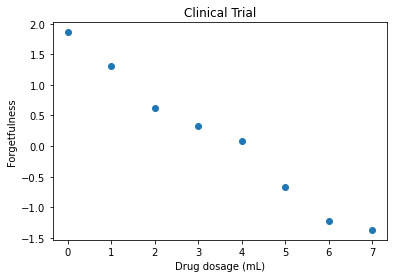

In [22]:
fig, ax = plt.subplots()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
_ = ax.scatter(x1, y)


Although it appears there is only one predictor ($x_1$), our model requires a second one (let's call it $x_0$) in order to allow for a $y$-intercept. Without this second variable, the line we fit to the plot would need to pass through the origin (0, 0). The $y$-intercept is constant across all the points so we can set it equal to 1 across the board:

In [23]:
x0 = np.ones(8)
x0

array([1., 1., 1., 1., 1., 1., 1., 1.])

Concatenate $x_0$ and $x_1$ into a matrix $X$:

In [24]:
X = np.concatenate((np.matrix(x0).T, np.matrix(x1).T), axis=1)
X

matrix([[1., 0.],
        [1., 1.],
        [1., 2.],
        [1., 3.],
        [1., 4.],
        [1., 5.],
        [1., 6.],
        [1., 7.]])


We can calculate the weights $w$ using the equation $w = X^+y$, since the original regression equation is $y=Xw$:

In [25]:
w = np.dot(np.linalg.pinv(X), y)
w

matrix([[ 1.76      , -0.46928571]])

The first weight corresponds to the $y$-intercept of the line, which is typically denoted as $b$:

In [26]:
b = np.asarray(w).reshape(-1)[0]
b

1.7599999999999985

In [27]:
np.asarray(w)

array([[ 1.76      , -0.46928571]])

In [28]:
np.asarray(w).reshape(-1)

array([ 1.76      , -0.46928571])

While the second weight corresponds to the slope of the line, which is typically denoted as $m$:

In [29]:
m = np.asarray(w).reshape(-1)[1]
m

-0.469285714285714

With the weights we can plot the line to confirm it fits the points:

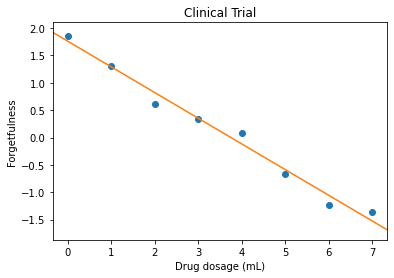

In [30]:
fig, ax = plt.subplots()

plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

ax.scatter(x1, y)

x_min, x_max = ax.get_xlim()
y_at_xmin = m*x_min + b
y_at_xmax = m*x_max + b

ax.set_xlim([x_min, x_max])
_ = ax.plot([x_min, x_max], [y_at_xmin, y_at_xmax], c='C01')